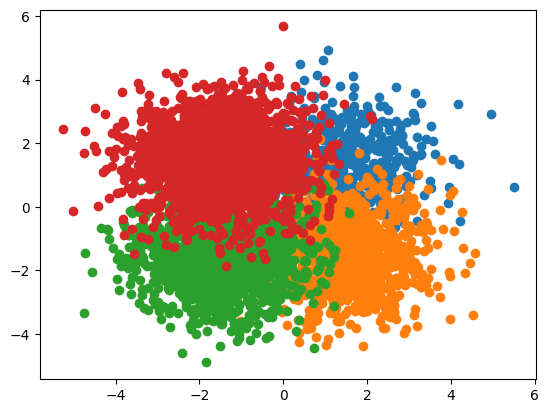

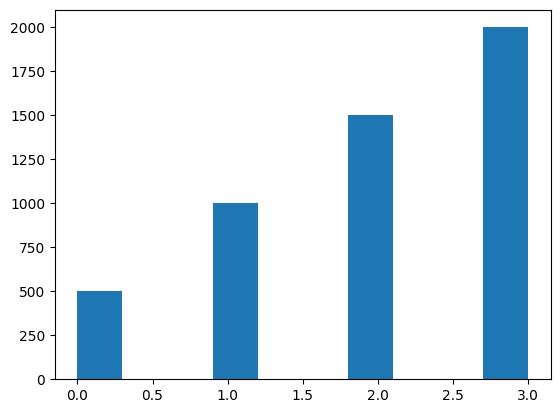

In [4]:
import torch
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from misc.metrics import *

samples_0 = torch.randn(500,2)+torch.tensor([1.5,1.5])
samples_1 = torch.randn(1000,2)+torch.tensor([1.5,-1.5])
samples_2 = torch.randn(1500,2)+torch.tensor([-1.5,-1.5])
samples_3 = torch.randn(2000,2)+torch.tensor([-1.5,1.5])
plt.scatter(samples_0[:,0].numpy(),samples_0[:,1].numpy())
plt.scatter(samples_1[:,0].numpy(),samples_1[:,1].numpy())
plt.scatter(samples_2[:,0].numpy(),samples_2[:,1].numpy())
plt.scatter(samples_3[:,0].numpy(),samples_3[:,1].numpy())
plt.show()

samples = torch.cat([samples_0, samples_1, samples_2, samples_3])
labels = torch.cat([torch.zeros(500), torch.ones(1000), 2*torch.ones(1500), 3*torch.ones(2000)]).long()

plt.hist(labels.numpy())
plt.show()


In [1]:
def sample_DGP(number_samples, prior):
    x = torch.distributions.Categorical(prior)
    mvn = torch.distributions.MultivariateNormal(means, torch.eye(2).unsqueeze(0).repeat(means.shape[0],1,1))
    labels  = torch.nn.functional.one_hot(x.sample(number_samples), num_classes = prior.shape[0]).unsqueeze(-1)
    obs = torch.sum(mvn.sample(number_samples)*labels, dim = 1)
    return obs, labels

obs,labels_obs = sample_DGP([1000], torch.ones(4)/4)
plt.scatter(obs[:,0], obs[:,1])

NameError: name 'torch' is not defined

In [5]:
class LogisticClassifier:
    def __init__(self,samples, labels,mu_beta=None, Sigma_beta=None):
        self.samples = samples
        self.labels = labels
        self.sample_dim = samples.shape[-1]
        self.C = labels.shape[-1]
        if mu_beta is not None:
            self.mu_beta = mu_beta
        else:
            self.mu_beta = torch.zeros((self.sample_dim+1)*self.C)
        if Sigma_beta is not None:
            self.Sigma_beta = Sigma_beta
        else: 
            self.Sigma_beta = torch.eye((self.sample_dim+1)*self.C)   
    
    def sample_beta_from_prior(self,num_samples):
        return torch.distributions.MultivariateNormal(self.mu_beta, self.Sigma_beta).sample(num_samples)
    
    def log_prob(self,samples, betas):
        log_prob = -torch.cat([samples, torch.ones(samples.shape[0],1)], dim = -1).unsqueeze(0).repeat(betas.shape[0],1,1)@betas.reshape(betas.shape[0],self.sample_dim+1,self.C)
        print(log_prob.shape)
        return log_prob - torch.logsumexp(log_prob, dim = -1, keepdim =True)
        
    def log_posterior_prob(self,betas):
        return torch.sum(self.log_prob(self.samples, betas)*self.labels.unsqueeze(0).repeat(betas.shape[0],1,1),dim = [-2,-1]) + torch.distributions.MultivariateNormal(self.mu_beta, self.Sigma_beta).log_prob(betas)
    

In [6]:
model = LogisticClassifier(samples, torch.nn.functional.one_hot(labels))
betas = model.sample_beta_from_prior([17])
print(torch.exp(model.log_prob(samples[:2], betas)).shape)
print(betas.shape)
print(model.log_posterior_prob(betas))


torch.Size([17, 2, 4])
torch.Size([17, 2, 4])
torch.Size([17, 12])
torch.Size([17, 5000, 4])
tensor([-18868.2539,  -7409.7197, -13122.3506, -16401.8926,  -9060.8301,
        -14421.8721,  -5958.4849, -15991.6982, -17923.7617, -23808.7969,
        -14985.1426,  -6395.7705, -12944.0850, -24082.9961, -26541.0176,
        -26137.7617, -29205.5977])


In [7]:
from markov_chain_monte_carlo import * 
sampler = MetropolisAdjustedLangevin(lambda beta: model.log_posterior_prob(beta),model.sample_beta_from_prior([1]).shape[-1],None, 100)
samples_beta_post = sampler.sample(0,tau=5e-4)

0it [00:00, ?it/s]


In [8]:
print(compute_accuracy(torch.mean(torch.exp(model.log_prob(samples,samples_beta_post)), dim = 0), labels))

torch.Size([100, 5000, 4])
tensor(0.3538)


torch.Size([100, 10000, 4])


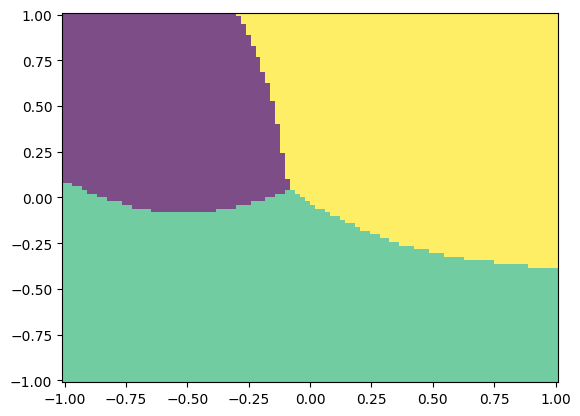

In [9]:
from utils import * 
plot_2d_function(lambda samples: torch.argmax(torch.mean(torch.exp(model.log_prob(samples,samples_beta_post)), dim = 0),dim = -1), bins = [100,100], range = [[-1,1],[-1,1]])

In [21]:
torch.mean(torch.exp(model.log_prob(torch.randn(1000,2)*5,samples_beta_post)), dim = [0,1])

tensor([0.2217, 0.2580, 0.2581, 0.2622], grad_fn=<MeanBackward1>)

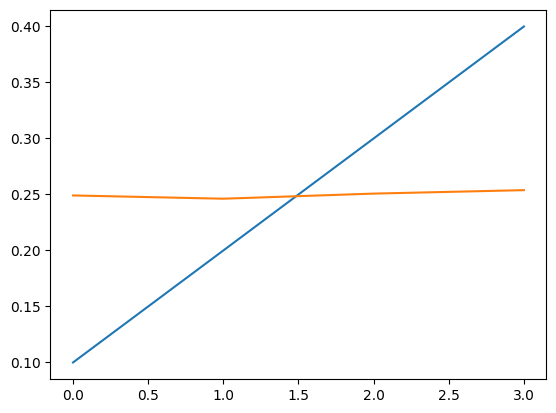

In [24]:
with torch.no_grad():

    plt.plot([500*(1/(500+1000+1500+2000)),1000*(1/(500+1000+1500+2000)),1500*(1/(500+1000+1500+2000)),2000*(1/(500+1000+1500+2000))])
    plt.plot(torch.mean(torch.exp(model.log_prob(torch.randn(10000,2)*50,samples_beta_post)), dim = [0,1]))
    plt.show()

In [9]:
class Classifier(torch.nn.Module):
    def __init__(self, samples, labels, hidden_dimensions=[]):
        super().__init__()
        assert samples.shape[0] == labels.shape[0], 'number of samples does not match number of samples'
        self.samples = samples
        self.labels = labels
        self.sample_dim = samples.shape[-1]
        self.C = labels.shape[-1]
        self.network_dimensions = [self.sample_dim] + hidden_dimensions + [self.C]
        network = []
        for h0, h1 in zip(self.network_dimensions, self.network_dimensions[1:]):
            network.extend([torch.nn.Linear(h0, h1), torch.nn.Tanh(), ])
        self.f = torch.nn.Sequential(*network)

    def log_prob(self, samples):
        temp = self.f.forward(samples)
        return temp - torch.logsumexp(temp, dim=-1, keepdim=True)

    def loss(self, samples, labels):
        return -torch.sum(self.log_prob(samples) * labels)

    def train(self, epochs, batch_size=None, unlabeled_samples=None, unlabeled_labels=None,
              test_samples=None, test_labels=None, recording_frequency=1, lr=5e-3, weight_decay=5e-5):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)
        optimizer = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = weight_decay)
        self.samples = self.samples.to(device)
        self.labels = self.labels.to(device)
        dataset = torch.utils.data.TensorDataset(self.samples, self.labels)
        train_accuracy_trace = []
        if unlabeled_samples is not None:
            unlabeled_accuracy_trace = []
        else:
            unlabeled_accuracy_trace = None
        if test_samples is not None:
            test_accuracy_trace = []
        else:
            test_accuracy_trace = None
        indices = []
        pbar = tqdm(range(epochs))
        for __ in pbar:
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for _, batch in enumerate(dataloader):
                optimizer.zero_grad()
                loss = self.loss(batch[0], batch[1])
                loss.backward()
                optimizer.step()
        self.to('cpu')

disc = Classifier(samples, torch.nn.functional.one_hot(labels), [5,5,5])
disc.train(100)

  5%|█████████▊                                                                                                                                                                                           | 5/100 [00:55<17:43, 11.20s/it]


KeyboardInterrupt: 

In [ ]:
#test_samples = 5*torch.randn(10000,2)
test_samples_0 = torch.randn(5000,2)+torch.tensor([1])
test_samples_1 = torch.randn(5000,2)-torch.tensor([1])
test_samples = torch.cat([samples_0, samples_1])
log_prob = disc.log_prob(test_samples)
print(torch.sum(torch.exp(log_prob), dim =0))

In [ ]:
generative_classifier